In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))


In [2]:
import sys
import importlib
from tqdm.notebook import tqdm
import copy

%load_ext autoreload
%autoreload 2

3738 examples loaded.


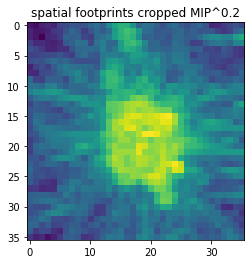

In [3]:
## TODO: avoid putting . in file names in future
## TODO: Include GPU Option

# Load modules
path_to_basic_neural_processing_modules = '/Users/josh/Documents/github_repos'
path_to_GCAMP_ROI = '/Users/josh/Documents/github_repos'
sys.path.append(path_to_basic_neural_processing_modules)
sys.path.append(path_to_GCAMP_ROI)
sys.path.append(path_to_GCAMP_ROI+'/GCaMP_ROI_classifier/new_stuff')
sys.path.append(path_to_GCAMP_ROI+'/GCaMP_ROI_classifier/End_User')
sys.path.append(path_to_GCAMP_ROI+'/GCaMP_ROI_classifier/End_User/simclr-models')

from basic_neural_processing_modules import *
from simclr_helpers import *
from util import *

# Load Data
# path_to_raw = f'./data/masks_20211202_balanced.h5' # raw data h5

path_to_raw = f'./data/AEG9_20210914_stat.npy' # raw data npy
path_to_y = f'./data/priya_all_rounds.npy' # raw data npy

# path_to_raw = f'./data/AEG_20210913_stat.npy' # raw data npy
# path_to_y = f'./data/ally_all_rounds.npy' # raw data npy

model_name = 'ResNet18_simCLR_model_202112078_EOD_transfmod=norm' # path to pth file
# path_to_classifier = './classifier-models/logreg_model_0.01.pkl' # path to logististic classifier pickle file
path_to_classifier = './classifier-models/logreg_model-model=ResNet18_simCLR_model_202112078_EOD_transfmod=norm-raw_filename=AEG9_20210914_stat-c=0.1.pkl' # path to logististic classifier pickle file
path_to_output_file = './latent-outputs/test-run-latents.pkl' # output results file
path_to_model = './simclr-models/' + model_name + '.pth'
h5_keys = ['RHmasks', 'SYTmasks', 'NPmasks'] # list of keys within h5 to concatenate

path_to_architecture = copy.copy(model_name) # path to .py file with architecture

if path_to_raw[-3:] == '.h5':
    data = load_h5(path_to_raw, h5_keys)
elif path_to_raw[-4:] == '.npy':
#     data = torch.as_tensor(statFile_to_spatialFootprints(path_to_raw, out_height_width=[36,36], max_footprint_width=539))
    data = torch.as_tensor(statFile_to_spatialFootprints(path_to_raw, out_height_width=[36,36], max_footprint_width=725))
else:
    raise ValueError('Data type not supported!')

if path_to_raw[-4:] == '.npy':
    labels = np.load(path_to_y).astype(int)
    labels = np.where(labels==42, np.ones_like(labels)*2, labels) - 1
    labels = labels[:, -2] # Use the second to last labeling column as the one to match
else:
    raise ValueError('Response y type not supported!')

data = drop_nan_imgs(data)
print(data.shape[0], 'examples loaded.')


In [4]:
# data = data[:2048]
# data = data[:data.shape[0]//100]


In [5]:
# Instantiate Model
model_file = importlib.import_module(path_to_architecture)
model = model_file.get_model(path_to_model)
model.eval();


In [6]:
# Create Data Sets / Data Loaders
dataset, dataloader = model_file.get_dataset_dataloader(data) ## TODO: Troubleshoot the runtime on this

In [7]:
# Get Model Latents
latents = dataloader_to_latents(dataloader, model).numpy()

  0%|          | 0/30 [00:00<?, ?it/s]

In [8]:
latents2 = latents.copy()

In [12]:
# Load Logistic Model
classifier_model = load_classifier_model(path_to_classifier)

In [13]:
# Predict ROIs — Save to File
preds = classifier_model.predict_proba(latents)
ret = get_returns(latents, classifier_model, path_to_model, path_to_classifier)
pickle_helpers.simple_save(ret, path_to_output_file)